In [1]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import optuna
import matplotlib.pyplot as plt

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/playground-series-s5e8/sample_submission.csv
/kaggle/input/playground-series-s5e8/train.csv
/kaggle/input/playground-series-s5e8/test.csv


In [33]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e8/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e8/test.csv')
sub_df = pd.read_csv('/kaggle/input/playground-series-s5e8/sample_submission.csv')

# Feature Engineering - experiments with new features

In [ ]:
# we can create separate column with flag for -1 value
# train_df['no_previous_contact'] = (train_df['pdays'] == -1).astype(int)
# test_df['no_previous_contact'] = (test_df['pdays'] == -1).astype(int)

# We can create additional column with pdays only without -1 values
# train_df['pdays_cleaned'] = train_df['pdays'].where(train_df['pdays'] != -1, np.nan) 
# test_df['pdays_cleaned'] = test_df['pdays'].where(test_df['pdays'] != -1, np.nan) 

# We can create additional column with numeric months
#train_df['month_as_num'] = train_df['month'].map({'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11, 'dec':12})
#test_df['month_as_num'] = test_df['month'].map({'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11, 'dec':12})

In [ ]:
def stability(x):
    if x=='management' or x=='technician' or x=='admin.' or x=='services':
        return 0
    elif x=='blue-collar' or x=='self-employed' or x=='entrepreneur':
        return 1
    else:
        return 2

train_df['job_stability'] = train_df['job'].apply(stability)

In [ ]:
def stability(x):
    #High
    if x=='management' or x=='entrepreneur' or x=='self-employed':
        return 0
    # Middle
    elif x=='technician' or x=='admin.' or x=='services':
        return 1
    # Low
    elif x=='blue-collar' or x=='housemaid':
        return 2
    # No earnings
    else:
        return 3

train_df['job_earnings'] = train_df['job'].apply(stability)

In [ ]:
def stability(x):
    #Not working
    if x=='retired' or x=='student' or x=='unemployed' or x=='unknown': 
        return 0
    # working
    else:
        return 1

train_df['job_is_working'] = train_df['job'].apply(stability)

In [ ]:
train_df['prev_success']=(train_df['poutcome'] == 'success').astype(int)

In [ ]:
train_df['duration_mult_age'] = train_df['duration'] * train_df['age']

In [ ]:
train_df['job_and_education'] = train_df['education'] + "_" + train_df['job']

In [ ]:
train_df['contact_plus_poutcome'] = train_df['contact'] + ' ' + train_df['poutcome']

In [ ]:
def stability(x):
    if x < 30: 
        return 0
    elif x >= 30 and x <= 60:
        return 1
    else:
        return 2

train_df['age_group'] = train_df['age'].apply(stability)

In [ ]:
def month(x):
    if x < 5:
        return 0
    elif x >= 5 and x <=8:
        return 1
    else:
        return 2 

train_df['month_group'] = train_df['month_as_num'].apply(month)

In [ ]:
def duration(x):
    # short
    if x < 120:
        return 0
    # medium
    elif x >= 120 and x <=250:
        return 1
    # long
    else:
        return 2

train_df['duration_long'] = train_df['duration'].apply(duration)

In [ ]:
mapping = ({'yes':1,"no":0})
train_df['loan_code'] = train_df['loan'].map(mapping)
train_df['housing_code'] = train_df['housing'].map(mapping)

train_df['loan_plus_housing'] = (train_df['loan_code']+train_df['housing_code']).astype(int)

In [ ]:
def add_no_and_unknown_counts(df):
    # Zliczanie 'NO' w kolumnach A, B, C
    df['no_count'] = df[['default', 'housing', 'loan']].eq('no').sum(axis=1)
    
    # Zliczanie 'UNKNOWN' w kolumnach D, E
    df['unknown_count'] = df[['education', 'contact','poutcome']].eq('unknown').sum(axis=1)
    
    return df

add_no_and_unknown_counts(train_df)


In [ ]:
# train_df['day'] = train_df['day'].astype(str)

In [ ]:
# train_df['month_as_num'] = train_df['month'].map({'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11, 'dec':12})
# DAYS_IN_YEAR = 31 * 12  
# # Number of the day in whole year
# train_df['day_of_year'] = (train_df['month_as_num'] - 1) * 31 + train_df['day']
# # Coding as cyclic data
# train_df['day_of_year_sin'] = np.sin(2 * np.pi * train_df['day_of_year'] / DAYS_IN_YEAR)
# train_df['day_of_year_cos'] = np.cos(2 * np.pi * train_df['day_of_year'] / DAYS_IN_YEAR)

## ML Experiments 

In [ ]:
train_df.columns

In [ ]:
train_df.info()

In [34]:


# ==== WPROWADŹ SWOJE KOLUMNY ====
categorical_cols = [ 'job', 'marital','education','default','housing','loan','contact','month','poutcome']#,  'no_count', 'unknown_count' ]  # 'loan_plus_housing', <- wpisz swoje kolumny kategoryczne
numerical_cols = ['age','balance', 'day', 'duration', 'campaign', 'pdays', 'previous']#'day_of_year_sin', 'day_of_year_cos' ]#, 'previous' ]#'pdays']#, 'previous']    # <- wpisz swoje kolumny numeryczne
target_col = 'y'


In [35]:
# ==== WCZYTAJ DANE ====
# train_df i test_df muszą być wcześniej wczytane

df = train_df.copy()
X = df[categorical_cols + numerical_cols].copy()
y = df[target_col].copy()

# ==== ENKODOWANIE DANYCH KATEGORYCZNYCH ==== Dla CATBOOSTA MOŻNA POMINĄ TYLKO PODAĆ LISTĘ
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# for col in ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]:
#     X[col] = X[col].astype("category")

# ==== K-FOLD USTAWIENIA ====
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ==== FUNKCJA TRENOWANIA MODELU ====
def train_model(X, y, params):
    scores = []
    importances = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        model = XGBClassifier(
            **params,
            eval_metric='auc',
            #enable_categorical=True,
            use_label_encoder=False,
            n_jobs=-1,
         #   scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
        )
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        importances.append(model.feature_importances_)

        print(f"Fold {fold+1} ROC-AUC: {auc:.5f}")

    print(f"\nŚredni ROC-AUC: {np.mean(scores):.5f}")
    avg_importances = np.mean(importances, axis=0)

    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': avg_importances
    }).sort_values(by='importance', ascending=False)

    print("\nFeature Importances:\n", importance_df)

    # Można też narysować
    importance_df.plot.bar(x='feature', y='importance', legend=False,  figsize=(10,5))
    plt.title("Średnia ważność cech (feature importance)")
    plt.show()

### Optuna configuration

In [36]:
def optuna_search(n_trials=30):
    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 5, 25),#('max_depth', 7, 15),#3-11
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'n_estimators': trial.suggest_int('n_estimators', 100, 4000),#('n_estimators', 200, 1200),#200-600
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
# Additional parameters for optuna serch
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 30),#('min_child_weight', 1, 28),
            'max_bin': trial.suggest_int('max_bin', 256, 4096),#('max_bin', 256, 1024),
            'grow_policy': 'lossguide' #trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        }

        scores = []
        for train_idx, val_idx in kf.split(X, y):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

            model = XGBClassifier(
                **params,
                eval_metric='auc',
                use_label_encoder=False,
                n_jobs=-1,
             #   scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
            )

            model.fit(X_train, y_train)
            y_pred = model.predict_proba(X_val)[:, 1]
            auc = roc_auc_score(y_val, y_pred)
            scores.append(auc)

        return np.mean(scores)


    study = optuna.create_study(direction='maximize')
    #Dodanie najlepszych param z przeszłości
    best_params_prev ={'max_depth': 14, 'learning_rate': 0.02701453181796079, 'n_estimators': 1095, 'subsample': 0.8023378542955938, 'colsample_bytree': 0.6104508809024989, 'gamma': 0.45421103247113814, 'reg_alpha': 1.1316365943111237, 'reg_lambda': 1.6012566769586427, 'min_child_weight': 18, 'max_bin': 989}  
    study.enqueue_trial(best_params_prev)
    study.optimize(objective, n_trials=n_trials)

    # Przekazanie stałych parametró (nie są zapisywane przez optunę do best_params)
    best_params = study.best_params.copy()
    best_params.update({'grow_policy': 'lossguide'})

    print("\nNajlepsze parametry Optuna:\n", best_params)
    print(f"Najlepszy ROC-AUC: {study.best_value:.5f}")

    # Trenowanie najlepszego modelu na koniec
    train_model(X, y, best_params)

In [ ]:
optuna_search(n_trials=120)

In [ ]:
# 19
# RAW DATA  With optuna XGBoost
# Public LB Score = 0.96878 bez CV w Submission
# Public LB Score = 0.96924 z CV w Submission 
Najlepsze parametry Optuna:
 {'max_depth': 10, 'learning_rate': 0.088542375425159, 'n_estimators': 353, 'subsample': 0.7933680125492807, 'colsample_bytree': 0.665859932215261, 'gamma': 1.9591038948726576, 'reg_alpha': 4.135658777432998, 'reg_lambda': 3.0378978111339086}
Najlepszy ROC-AUC: 0.96788
Fold 1 ROC-AUC: 0.96859
Fold 2 ROC-AUC: 0.96726
Fold 3 ROC-AUC: 0.96728
Fold 4 ROC-AUC: 0.96853
Fold 5 ROC-AUC: 0.96773

Średni ROC-AUC: 0.96788

Feature Importances:
       feature  importance
12   duration    0.255548
6     contact    0.171966
4     housing    0.160483
8    poutcome    0.070366
7       month    0.061991
14      pdays    0.056551
5        loan    0.044870
10    balance    0.037885
11        day    0.022941
1     marital    0.022816
13   campaign    0.021023
9         age    0.017168
2   education    0.016198
0         job    0.015291
15   previous    0.013801
3     default    0.011103

In [ ]:
# V20
# RAW DATA  With optuna XGBoost bez cechy previous 
# Public LB Score = 0.96914 bez z CV w Submission 
# Public LB Score = 0.96942  z CV w Submission 
Najlepsze parametry Optuna:
 {'max_depth': 9, 'learning_rate': 0.11410300715659989, 'n_estimators': 368, 'subsample': 0.907977121199552, 'colsample_bytree': 0.6014268962223818, 'gamma': 0.7012459904827175, 'reg_alpha': 4.361523501536162, 'reg_lambda': 4.294305690785547}
Najlepszy ROC-AUC: 0.96787
Fold 1 ROC-AUC: 0.96860
Fold 2 ROC-AUC: 0.96714
Fold 3 ROC-AUC: 0.96721
Fold 4 ROC-AUC: 0.96854
Fold 5 ROC-AUC: 0.96785

Średni ROC-AUC: 0.96787

Feature Importances:
       feature  importance
12   duration    0.361053
6     contact    0.166310
4     housing    0.132702
8    poutcome    0.083217
7       month    0.062788
5        loan    0.041027
14      pdays    0.026778
10    balance    0.024013
11        day    0.019122
2   education    0.016243
13   campaign    0.016015
1     marital    0.015528
9         age    0.015053
0         job    0.011771
3     default    0.008379

In [ ]:
# V21
# RAW DATA  With optuna XGBoost bez cechy previous  / z enable_categorical=True (XGBoost sam obsługuje kategorie)
# Public LB Score = 0.96844 bez CV w Submission
# Public LB Score = 0.96891 z CV w Submission 
Najlepsze parametry Optuna:
 {'max_depth': 8, 'learning_rate': 0.07733762308533498, 'n_estimators': 469, 'subsample': 0.9190881144681935, 'colsample_bytree': 0.7461531023839627, 'gamma': 2.06998675412871, 'reg_alpha': 1.3641260353935682, 'reg_lambda': 4.343504135311625}
Najlepszy ROC-AUC: 0.96775
Fold 1 ROC-AUC: 0.96845
Fold 2 ROC-AUC: 0.96711
Fold 3 ROC-AUC: 0.96709
Fold 4 ROC-AUC: 0.96834
Fold 5 ROC-AUC: 0.96777

Średni ROC-AUC: 0.96775

Feature Importances:
       feature  importance
12   duration    0.324780
6     contact    0.173031
4     housing    0.120737
8    poutcome    0.118197
7       month    0.067933
5        loan    0.038657
14      pdays    0.029699
10    balance    0.022180
11        day    0.019063
1     marital    0.017264
0         job    0.016717
13   campaign    0.016680
9         age    0.013868
2   education    0.011933
3     default    0.009262

In [ ]:
# V22
# optuna XGBoost bez cechy previous bez enable_categorical=True, pdays rozdzielone, 'days' jako cat, loan_plus_housing, deep_debt
# Public LB Score = 0.96848 bez CV w Submission
# Public LB Score = 0.96886 z CV w Submission 
Najlepsze parametry Optuna:
 {'max_depth': 9, 'learning_rate': 0.07135259874564061, 'n_estimators': 530, 'subsample': 0.8521429564138164, 'colsample_bytree': 0.7823863939520701, 'gamma': 2.9329829182260148, 'reg_alpha': 3.2901322430190185, 'reg_lambda': 1.268405294791835}
Najlepszy ROC-AUC: 0.96765
Fold 1 ROC-AUC: 0.96834
Fold 2 ROC-AUC: 0.96694
Fold 3 ROC-AUC: 0.96709
Fold 4 ROC-AUC: 0.96824
Fold 5 ROC-AUC: 0.96761

Średni ROC-AUC: 0.96765

Feature Importances:
                 feature  importance
15             duration    0.239886
6               contact    0.185347
10    loan_plus_housing    0.145455
9   no_previous_contact    0.078178
8              poutcome    0.052764
7                 month    0.051926
17        pdays_cleaned    0.048056
4               housing    0.045511
14              balance    0.025864
5                  loan    0.018386
1               marital    0.018161
16             campaign    0.017235
12                  day    0.016298
2             education    0.014973
13                  age    0.013090
0                   job    0.011265
3               default    0.009477
11            deep_debt    0.008127

In [ ]:
# V23
# optuna XGBoost bez cechy previous bez enable_categorical=True, pdays rozdzielone, 'days' jako num, loan_plus_housing
# Public LB Score = 0.96870 bez CV w Submission
# Public LB Score = 0.96895 z CV w Submission 
Najlepsze parametry Optuna:
 {'max_depth': 8, 'learning_rate': 0.12763052427108496, 'n_estimators': 411, 'subsample': 0.953989568332575, 'colsample_bytree': 0.6023438935073028, 'gamma': 0.019491768244553676, 'reg_alpha': 3.961328967768697, 'reg_lambda': 1.131707666650681}

Najlepszy ROC-AUC: 0.96782
Fold 1 ROC-AUC: 0.96848
Fold 2 ROC-AUC: 0.96723
Fold 3 ROC-AUC: 0.96712
Fold 4 ROC-AUC: 0.96847
Fold 5 ROC-AUC: 0.96778

Średni ROC-AUC: 0.96782

Feature Importances:
                 feature  importance
13             duration    0.276787
6               contact    0.190028
10    loan_plus_housing    0.082526
9   no_previous_contact    0.079404
4               housing    0.067073
7                 month    0.058600
15        pdays_cleaned    0.042893
8              poutcome    0.041466
12              balance    0.033900
5                  loan    0.023026
16                  day    0.020086
14             campaign    0.020008
11                  age    0.016162
1               marital    0.014663
2             education    0.013929
3               default    0.009995
0                   job    0.009455

In [ ]:
# V24
# optuna XGBoost bez cechy previous bez enable_categorical=True, pdays rozdzielone, 'days' jako num, loan_plus_housing + col no_count + unknown_count
# Public LB Score = 96831 bez CV w Submission
# Public LB Score = 0.96867 z CV w Submission 
Najlepsze parametry Optuna:
 {'max_depth': 7, 'learning_rate': 0.16686222138398568, 'n_estimators': 359, 'subsample': 0.9687425335082887, 'colsample_bytree': 0.8948829860260885, 'gamma': 0.3972938375538543, 'reg_alpha': 4.575416910972401, 'reg_lambda': 2.201098085025244}

Najlepszy ROC-AUC: 0.96756
Fold 1 ROC-AUC: 0.96836
Fold 2 ROC-AUC: 0.96696
Fold 3 ROC-AUC: 0.96680
Fold 4 ROC-AUC: 0.96824
Fold 5 ROC-AUC: 0.96744

Średni ROC-AUC: 0.96756

Feature Importances:
                 feature  importance
11             no_count    0.273360
15             duration    0.209798
6               contact    0.118712
12        unknown_count    0.075067
9   no_previous_contact    0.067390
7                 month    0.044799
17        pdays_cleaned    0.040017
8              poutcome    0.038668
14              balance    0.016463
2             education    0.015356
10    loan_plus_housing    0.013421
5                  loan    0.013264
18                  day    0.013007
4               housing    0.012936
16             campaign    0.012547
1               marital    0.012498
13                  age    0.009314
0                   job    0.007695
3               default    0.005689

In [ ]:
# V25
# optuna XGBoost bez cechy previous bez enable_categorical=True, pdays rozdzielone, 'days' jako num + col no_count + unknown_count  --bez loan_plus_housing - 
# Public LB Score = 0.96883 bez CV w Submission
# Public LB Score = 0.96900 z CV w Submission 
Najlepsze parametry Optuna:
 {'max_depth': 10, 'learning_rate': 0.05576641173716932, 'n_estimators': 492, 'subsample': 0.7568779660915822, 'colsample_bytree': 0.6384212073745787, 'gamma': 2.0698430928317997, 'reg_alpha': 2.9165075287479447, 'reg_lambda': 2.040935203862332}

Najlepszy ROC-AUC: 0.96792
Fold 1 ROC-AUC: 0.96869
Fold 2 ROC-AUC: 0.96731
Fold 3 ROC-AUC: 0.96734
Fold 4 ROC-AUC: 0.96847
Fold 5 ROC-AUC: 0.96779

Średni ROC-AUC: 0.96792

Feature Importances:
                 feature  importance
14             duration    0.241594
10             no_count    0.142254
6               contact    0.121863
9   no_previous_contact    0.109933
11        unknown_count    0.057236
7                 month    0.056043
8              poutcome    0.044780
16        pdays_cleaned    0.040740
4               housing    0.033472
5                  loan    0.022579
13              balance    0.022401
17                  day    0.018681
15             campaign    0.018105
1               marital    0.017343
2             education    0.015570
12                  age    0.014035
0                   job    0.011947
3               default    0.011424

In [ ]:
# V26
# RAW DATA  With optuna XGBoost bez cechy previous + pdays rozdzielone
# Public LB Score = ----------- bez z CV w Submission 
# Public LB Score = 0.96911 z CV w Submission 
Najlepsze parametry Optuna:
 {'max_depth': 10, 'learning_rate': 0.0832583908499121, 'n_estimators': 551, 'subsample': 0.8758220883852462, 'colsample_bytree': 0.6810585417529508, 'gamma': 2.389202320659961, 'reg_alpha': 0.9587487104983587, 'reg_lambda': 4.103575772005836}
Najlepszy ROC-AUC: 0.96779
Fold 1 ROC-AUC: 0.96867
Fold 2 ROC-AUC: 0.96720
Fold 3 ROC-AUC: 0.96721
Fold 4 ROC-AUC: 0.96839
Fold 5 ROC-AUC: 0.96750

Średni ROC-AUC: 0.96779

Feature Importances:
                 feature  importance
13             duration    0.243189
4               housing    0.139019
6               contact    0.138376
9   no_previous_contact    0.123810
8              poutcome    0.074177
7                 month    0.060123
5                  loan    0.039687
15        pdays_cleaned    0.038699
11              balance    0.027620
12                  day    0.020040
1               marital    0.019900
14             campaign    0.018159
10                  age    0.015864
2             education    0.015750
0                   job    0.014219
3               default    0.011369

In [ ]:
# V27
# RAW DATA  With optuna XGBoost bez cechy previous  + col no_count
# Public LB Score = -------------- bez z CV w Submission 
# Public LB Score = 0.96901 z CV w Submission 

Najlepsze parametry Optuna:
 {'max_depth': 11, 'learning_rate': 0.07256654502258869, 'n_estimators': 264, 'subsample': 0.7252245807583018, 'colsample_bytree': 0.7225278113013671, 'gamma': 3.044364512727718, 'reg_alpha': 4.9552240198208874, 'reg_lambda': 3.7933495200093277}
Najlepszy ROC-AUC: 0.96786
Fold 1 ROC-AUC: 0.96868
Fold 2 ROC-AUC: 0.96723
Fold 3 ROC-AUC: 0.96730
Fold 4 ROC-AUC: 0.96846
Fold 5 ROC-AUC: 0.96764

Średni ROC-AUC: 0.96786

Feature Importances:
       feature  importance
13   duration    0.261933
6     contact    0.184296
9    no_count    0.156206
4     housing    0.073811
8    poutcome    0.064446
7       month    0.057004
15      pdays    0.043390
11    balance    0.026560
5        loan    0.025262
12        day    0.018575
1     marital    0.018476
14   campaign    0.017962
2   education    0.014880
10        age    0.014734
0         job    0.012134
3     default    0.010333

In [ ]:
# V28
# RAW DATA  With optuna XGBoost bez cechy previous   + col unknown_count
# Public LB Score = -------------- bez z CV w Submission 
# Public LB Score = 0.96913 z CV w Submission 
Najlepsze parametry Optuna:
 {'max_depth': 11, 'learning_rate': 0.05314481725365295, 'n_estimators': 485, 'subsample': 0.6616608475014232, 'colsample_bytree': 0.6827154636682595, 'gamma': 1.99699754127895, 'reg_alpha': 3.8063665621075478, 'reg_lambda': 1.325699284371194}
Najlepszy ROC-AUC: 0.96787
Fold 1 ROC-AUC: 0.96866
Fold 2 ROC-AUC: 0.96720
Fold 3 ROC-AUC: 0.96733
Fold 4 ROC-AUC: 0.96837
Fold 5 ROC-AUC: 0.96778

Średni ROC-AUC: 0.96787

Feature Importances:
           feature  importance
13       duration    0.246059
4         housing    0.147026
6         contact    0.120959
9   unknown_count    0.095596
8        poutcome    0.083078
7           month    0.063654
5            loan    0.042798
15          pdays    0.040915
11        balance    0.030914
12            day    0.022072
1         marital    0.021628
14       campaign    0.020466
2       education    0.018847
10            age    0.018099
0             job    0.015135
3         default    0.012754

# __________________ NOWE EXPERYMENTY _____________________

In [ ]:
## Sprawdź job_edu matrix
# RAW DATA  With optuna XGBoost bez cechy previous   + col job_edu
# Public LB Score = -------------- bez z CV w Submission 
# Public LB Score =  z CV w Submission 
Najlepsze parametry Optuna:
 {'max_depth': 9, 'learning_rate': 0.08212321514497181, 'n_estimators': 523, 'subsample': 0.7525320809093057, 'colsample_bytree': 0.6765190265893073, 'gamma': 3.0377809209553503, 'reg_alpha': 3.625755897052336, 'reg_lambda': 0.18705008615849394}
Najlepszy ROC-AUC: 0.96773
Fold 1 ROC-AUC: 0.96851
Fold 2 ROC-AUC: 0.96708
Fold 3 ROC-AUC: 0.96716
Fold 4 ROC-AUC: 0.96832
Fold 5 ROC-AUC: 0.96758

Średni ROC-AUC: 0.96773

Feature Importances:
               feature  importance
13           duration    0.260276
4             housing    0.164296
6             contact    0.159799
8            poutcome    0.090988
7               month    0.066868
5                loan    0.045981
15              pdays    0.039986
11            balance    0.030999
12                day    0.022041
1             marital    0.021875
14           campaign    0.020257
10                age    0.017447
2           education    0.016907
0                 job    0.015690
9   job_and_education    0.013969
3             default    0.012622

In [ ]:
# V30
# bez weight balanced
# RAW DATA  With optuna XGBoost bez cechy previous, no XGB weight balanced
# Public LB Score = -------------- bez z CV w Submission 
# Public LB Score = 0.96933 z CV w Submission 
Najlepsze parametry Optuna:
 {'max_depth': 11, 'learning_rate': 0.11206031547278855, 'n_estimators': 501, 'subsample': 0.6131323770348673, 'colsample_bytree': 0.6094568889243491, 'gamma': 2.043078715855179, 'reg_alpha': 2.0852138450654643, 'reg_lambda': 4.796903414902333}
Najlepszy ROC-AUC: 0.96812
Fold 1 ROC-AUC: 0.96889
Fold 2 ROC-AUC: 0.96754
Fold 3 ROC-AUC: 0.96766
Fold 4 ROC-AUC: 0.96853
Fold 5 ROC-AUC: 0.96799

Średni ROC-AUC: 0.96812

Feature Importances:
       feature  importance
12   duration    0.222174
4     housing    0.181200
6     contact    0.177984
8    poutcome    0.135613
5        loan    0.054855
7       month    0.054545
14      pdays    0.029267
10    balance    0.021182
13   campaign    0.021124
11        day    0.021034
2   education    0.020611
1     marital    0.019631
9         age    0.017880
0         job    0.013251
3     default    0.009648

In [ ]:
# V31
# bez weight balanced
# RAW DATA  With optuna XGBoost z previous, no XGB weight balanced
# Public LB Score = -------------- bez z CV w Submission 
# Public LB Score = 0.96955 z CV w Submission 

Najlepsze parametry Optuna:
 {'max_depth': 9, 'learning_rate': 0.12075088743052882, 'n_estimators': 492, 'subsample': 0.8707220500188539, 'colsample_bytree': 0.6688353258198634, 'gamma': 0.7893885646435537, 'reg_alpha': 0.7438751764100405, 'reg_lambda': 3.4902318090320925}
Najlepszy ROC-AUC: 0.96819
Fold 1 ROC-AUC: 0.96885
Fold 2 ROC-AUC: 0.96757
Fold 3 ROC-AUC: 0.96767
Fold 4 ROC-AUC: 0.96879
Fold 5 ROC-AUC: 0.96806

Średni ROC-AUC: 0.96819

Feature Importances:
       feature  importance
12   duration    0.218552
4     housing    0.176054
6     contact    0.158084
8    poutcome    0.082320
14      pdays    0.065794
7       month    0.064837
5        loan    0.055597
10    balance    0.032892
11        day    0.023744
13   campaign    0.022558
1     marital    0.021204
9         age    0.019373
2   education    0.019224
0         job    0.014700
3     default    0.012958
15   previous    0.012108

In [ ]:
# V32
## RAW DATA  With optuna XGBoost 10 folds z previous bez scale_pos_weight
# Public LB Score = -------------- bez z CV w Submission 
# Public LB Score = 0.96944 z CV w Submission 
Najlepsze parametry Optuna:
 {'max_depth': 9, 'learning_rate': 0.06227423103688831, 'n_estimators': 556, 'subsample': 0.9298469326500857, 'colsample_bytree': 0.8895510541144902, 'gamma': 0.48209725496163736, 'reg_alpha': 3.796950975692023, 'reg_lambda': 1.6612550809713749}
Najlepszy ROC-AUC: 0.96849
Fold 1 ROC-AUC: 0.96991
Fold 2 ROC-AUC: 0.96855
Fold 3 ROC-AUC: 0.96764
Fold 4 ROC-AUC: 0.96827
Fold 5 ROC-AUC: 0.96771
Fold 6 ROC-AUC: 0.96819
Fold 7 ROC-AUC: 0.96925
Fold 8 ROC-AUC: 0.96863
Fold 9 ROC-AUC: 0.96882
Fold 10 ROC-AUC: 0.96793

Średni ROC-AUC: 0.96849

Feature Importances:
       feature  importance
12   duration    0.227937
4     housing    0.207634
6     contact    0.201319
8    poutcome    0.078979
7       month    0.057670
14      pdays    0.055200
5        loan    0.045558
10    balance    0.021865
13   campaign    0.019530
11        day    0.017168
1     marital    0.015472
2   education    0.013478
9         age    0.012875
0         job    0.010124
15   previous    0.007938
3     default    0.007251

In [ ]:
# V33
## RAW DATA  With optuna XGBoost 10 folds no previuous z scale_pos_weight
# Public LB Score = -------------- bez z CV w Submission 
# Public LB Score = 0.96903 z CV w Submission 

Najlepsze parametry Optuna:
 {'max_depth': 11, 'learning_rate': 0.04545133522176488, 'n_estimators': 481, 'subsample': 0.7684178974094136, 'colsample_bytree': 0.7986253830153623, 'gamma': 4.481651671654932, 'reg_alpha': 3.3989357087069094, 'reg_lambda': 0.557383341841934}
Najlepszy ROC-AUC: 0.96801
Fold 1 ROC-AUC: 0.96931
Fold 2 ROC-AUC: 0.96811
Fold 3 ROC-AUC: 0.96702
Fold 4 ROC-AUC: 0.96789
Fold 5 ROC-AUC: 0.96726
Fold 6 ROC-AUC: 0.96758
Fold 7 ROC-AUC: 0.96883
Fold 8 ROC-AUC: 0.96835
Fold 9 ROC-AUC: 0.96813
Fold 10 ROC-AUC: 0.96766

Średni ROC-AUC: 0.96801

Feature Importances:
       feature  importance
12   duration    0.272672
6     contact    0.210457
4     housing    0.171070
8    poutcome    0.075329
7       month    0.057601
5        loan    0.040058
14      pdays    0.039956
10    balance    0.022206
11        day    0.018679
13   campaign    0.018674
1     marital    0.018211
2   education    0.016141
9         age    0.015146
0         job    0.013055
3     default    0.010745

In [ ]:
# V34
#'min_child_weight': trial.suggest_int('min_child_weight', 1, 28),
#'max_bin': trial.suggest_int('max_bin', 256, 1024),
#'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),

## RAW DATA  With optuna XGBoost 5 folds, no previuous z scale_pos_weight, n_trial=40
# Public LB Score = -------------- bez z CV w Submission 
# Public LB Score = 0.97147 z CV w Submission 
Najlepsze parametry Optuna:
 {'max_depth': 11, 'learning_rate': 0.11017938521753814, 'n_estimators': 447, 'subsample': 0.7200594556282529, 'colsample_bytree': 0.7298687513204829, 'gamma': 3.7349463296256253, 'reg_alpha': 2.2870628091572853, 'reg_lambda': 0.3821213759830635, 'min_child_weight': 22, 'max_bin': 965, 'grow_policy': 'lossguide'}
Najlepszy ROC-AUC: 0.97010
Fold 1 ROC-AUC: 0.97083
Fold 2 ROC-AUC: 0.96943
Fold 3 ROC-AUC: 0.96969
Fold 4 ROC-AUC: 0.97058
Fold 5 ROC-AUC: 0.96998

Średni ROC-AUC: 0.97010

Feature Importances:
       feature  importance
12   duration    0.223254
6     contact    0.207627
4     housing    0.139693
8    poutcome    0.109910
7       month    0.061940
5        loan    0.057761
14      pdays    0.044007
10    balance    0.023326
11        day    0.021511
1     marital    0.021244
13   campaign    0.020844
2   education    0.020157
9         age    0.017688
3     default    0.015842
0         job    0.015194


In [ ]:
# V35
#'min_child_weight': trial.suggest_int('min_child_weight', 1, 28),
#'max_bin': trial.suggest_int('max_bin', 256, 1024),
#'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),

## RAW DATA  With optuna XGBoost 5 folds, z previuous, no scale_pos_weight, n_trial=40
# Public LB Score = -------------- bez z CV w Submission 
# Public LB Score = 0.97150 z CV w Submission 
Najlepsze parametry Optuna:
 {'max_depth': 10, 'learning_rate': 0.11419656400547268, 'n_estimators': 382, 'subsample': 0.8761249869278733, 'colsample_bytree': 0.9302155455418724, 'gamma': 0.922723932134517, 'reg_alpha': 1.0912230662828875, 'reg_lambda': 2.6136637861620295, 'min_child_weight': 23, 'max_bin': 923, 'grow_policy': 'lossguide'}
Najlepszy ROC-AUC: 0.97018
Fold 1 ROC-AUC: 0.97100
Fold 2 ROC-AUC: 0.96970
Fold 3 ROC-AUC: 0.96957
Fold 4 ROC-AUC: 0.97062
Fold 5 ROC-AUC: 0.97004

Średni ROC-AUC: 0.97018

Feature Importances:
       feature  importance
6     contact    0.217533
4     housing    0.180848
12   duration    0.163919
8    poutcome    0.099551
5        loan    0.072457
14      pdays    0.068149
7       month    0.055700
13   campaign    0.021170
10    balance    0.019574
11        day    0.018934
1     marital    0.018691
2   education    0.016664
9         age    0.014356
0         job    0.011392
3     default    0.011143
15   previous    0.009918

In [ ]:
# V36
#'min_child_weight': trial.suggest_int('min_child_weight', 1, 28),
#'max_bin': trial.suggest_int('max_bin', 256, 1024),
#'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),

## RAW DATA  With optuna XGBoost 5 folds, z previuous, z scale_pos_weight, n_trial=40
# Public LB Score = -------------- bez z CV w Submission 
# Public LB Score = 0.97142 z CV w Submission 
Najlepsze parametry Optuna:
 {'max_depth': 10, 'learning_rate': 0.08502933965618005, 'n_estimators': 492, 'subsample': 0.8475568692723069, 'colsample_bytree': 0.7937125702771929, 'gamma': 2.090595137285895, 'reg_alpha': 2.2649299117163197, 'reg_lambda': 4.582521266327681, 'min_child_weight': 18, 'max_bin': 850, 'grow_policy': 'lossguide'}
Najlepszy ROC-AUC: 0.97005
Fold 1 ROC-AUC: 0.97077
Fold 2 ROC-AUC: 0.96942
Fold 3 ROC-AUC: 0.96942
Fold 4 ROC-AUC: 0.97058
Fold 5 ROC-AUC: 0.97004

Średni ROC-AUC: 0.97005

Feature Importances:
       feature  importance
12   duration    0.209513
6     contact    0.177149
4     housing    0.176229
8    poutcome    0.087599
14      pdays    0.063545
7       month    0.059903
5        loan    0.055038
10    balance    0.030265
1     marital    0.023010
13   campaign    0.021739
11        day    0.020944
2   education    0.016545
3     default    0.015434
9         age    0.015278
15   previous    0.014785
0         job    0.013024

In [ ]:
# V37
#'max_depth' 7, 15
#'n_estimators': 200, 1200)
#'min_child_weight': trial.suggest_int('min_child_weight', 1, 28),
#'max_bin': trial.suggest_int('max_bin', 256, 1024),
#'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),

## RAW DATA  With optuna XGBoost 5 folds, no previuous z scale_pos_weight, n_trial=150
# Public LB Score = -------------- bez z CV w Submission 
# Public LB Score = 0.97179 z CV w Submission 
with value: 0.9706775741350937 and parameters: {'max_depth': 13, 'learning_rate': 0.051597964533266545, 'n_estimators': 1199, 'subsample': 0.9486843342638015, 'colsample_bytree': 0.7012804860738411, 'gamma': 1.4669905642678631, 'reg_alpha': 3.8750691242340927, 'reg_lambda': 3.5772297879036534, 'min_child_weight': 17, 'max_bin': 1024, 'grow_policy': 'depthwise'}
with value: 0.9705044230332828 and parameters: {'max_depth': 11, 'learning_rate': 0.04259500015997499, 'n_estimators': 865, 'subsample': 0.8394497002983581, 'colsample_bytree': 0.6339824727397483, 'gamma': 3.1012031163583353, 'reg_alpha': 2.7765300977121243, 'reg_lambda': 3.97300406750927, 'min_child_weight': 10, 'max_bin': 1000, 'grow_policy': 'lossguide'}. Best is trial 69 with value: 0.9705044230332828.

Najlepsze parametry Optuna:
 {'max_depth': 13, 'learning_rate': 0.051597964533266545, 'n_estimators': 1199, 'subsample': 0.9486843342638015, 'colsample_bytree': 0.7012804860738411, 'gamma': 1.4669905642678631, 'reg_alpha': 3.8750691242340927, 'reg_lambda': 3.5772297879036534, 'min_child_weight': 17, 'max_bin': 1024, 'grow_policy': 'depthwise'}
Najlepszy ROC-AUC: 0.97068
Fold 1 ROC-AUC: 0.97139
Fold 2 ROC-AUC: 0.97019
Fold 3 ROC-AUC: 0.97006
Fold 4 ROC-AUC: 0.97114
Fold 5 ROC-AUC: 0.97061

Średni ROC-AUC: 0.97068

Feature Importances:
       feature  importance
12   duration    0.229621
6     contact    0.219436
4     housing    0.148120
8    poutcome    0.105272
7       month    0.061781
5        loan    0.058197
14      pdays    0.044451
10    balance    0.019561
11        day    0.018427
1     marital    0.018276
13   campaign    0.018216
2   education    0.016455
3     default    0.015356
9         age    0.014330
0         job    0.012503

In [ ]:
# V38
#'min_child_weight': trial.suggest_int('min_child_weight', 1, 28),
#'max_bin': trial.suggest_int('max_bin', 256, 1024),
#'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),

## RAW DATA  With optuna XGBoost 5 folds, no previuous z scale_pos_weight, n_trial=40, new cols  sin/cos
# Public LB Score = -------------- bez z CV w Submission 
# Public LB Score = 0.97147 z CV w Submission 
Najlepsze parametry Optuna:
 {'max_depth': 10, 'learning_rate': 0.12547508160977527, 'n_estimators': 558, 'subsample': 0.9603467732508381, 'colsample_bytree': 0.6775794698624192, 'gamma': 1.0653180442504713, 'reg_alpha': 3.49579539155107, 'reg_lambda': 3.985155368089634, 'min_child_weight': 12, 'max_bin': 787, 'grow_policy': 'lossguide'}
Najlepszy ROC-AUC: 0.96976
Fold 1 ROC-AUC: 0.97053
Fold 2 ROC-AUC: 0.96929
Fold 3 ROC-AUC: 0.96914
Fold 4 ROC-AUC: 0.97021
Fold 5 ROC-AUC: 0.96964

Średni ROC-AUC: 0.96976

Feature Importances:
             feature  importance
12         duration    0.226128
6           contact    0.220253
4           housing    0.124076
8          poutcome    0.091663
5              loan    0.050570
14            pdays    0.050106
16  day_of_year_cos    0.038176
15  day_of_year_sin    0.035609
7             month    0.031246
10          balance    0.025604
3           default    0.018384
11              day    0.017046
13         campaign    0.016098
1           marital    0.015935
2         education    0.014467
9               age    0.012868
0               job    0.011770


In [ ]:
# V40
#'max_depth' 7, 15
#'n_estimators': 200, 1200)
#'min_child_weight': trial.suggest_int('min_child_weight', 1, 28),
#'max_bin': trial.suggest_int('max_bin', 256, 1024),
#'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),

## RAW DATA  With optuna XGBoost 5 folds, z previuous, bez scale_pos_weight, n_trial=150
# Public LB Score = -------------- bez z CV w Submission 
# Public LB Score = 0.97186  z CV w Submission 

Najlepsze parametry Optuna:
 {'max_depth': 14, 'learning_rate': 0.02701453181796079, 'n_estimators': 1095, 'subsample': 0.8023378542955938, 'colsample_bytree': 0.6104508809024989, 'gamma': 0.45421103247113814, 'reg_alpha': 1.1316365943111237, 'reg_lambda': 1.6012566769586427, 'min_child_weight': 18, 'max_bin': 989}
Najlepszy ROC-AUC: 0.97104
Fold 1 ROC-AUC: 0.97187
Fold 2 ROC-AUC: 0.97052
Fold 3 ROC-AUC: 0.97061
Fold 4 ROC-AUC: 0.97139
Fold 5 ROC-AUC: 0.97081

Średni ROC-AUC: 0.97104

Feature Importances:
       feature  importance
6     contact    0.198984
12   duration    0.163953
8    poutcome    0.148052
4     housing    0.123673
5        loan    0.066679
7       month    0.065384
14      pdays    0.063445
15   previous    0.023446
10    balance    0.022897
1     marital    0.021821
11        day    0.020702
13   campaign    0.019559
2   education    0.016312
9         age    0.016251
3     default    0.015141
0         job    0.013703

In [28]:
#V45
beeest_param = {'max_depth': 16, 'learning_rate': 0.0444106455843034, 'n_estimators': 2746, 'subsample': 0.8385441637974808, 'colsample_bytree': 0.8660799923129452, 'gamma': 0.6988818955694143, 'reg_alpha': 4.026337640164294, 'reg_lambda': 4.0256180856994215, 'min_child_weight': 3, 'max_bin': 1904, 'grow_policy': 'lossguide'}


Fold 1 ROC-AUC: 0.97322
Fold 2 ROC-AUC: 0.97202
Fold 3 ROC-AUC: 0.97177
Fold 4 ROC-AUC: 0.97278
Fold 5 ROC-AUC: 0.97241

Średni ROC-AUC: 0.97244

Feature Importances:
       feature  importance
4     housing    0.240487
6     contact    0.187580
12   duration    0.145691
8    poutcome    0.096370
14      pdays    0.064628
7       month    0.063831
5        loan    0.043229
13   campaign    0.022724
10    balance    0.022455
11        day    0.020449
1     marital    0.019210
2   education    0.017432
9         age    0.016351
0         job    0.013964
3     default    0.013399
15   previous    0.012203


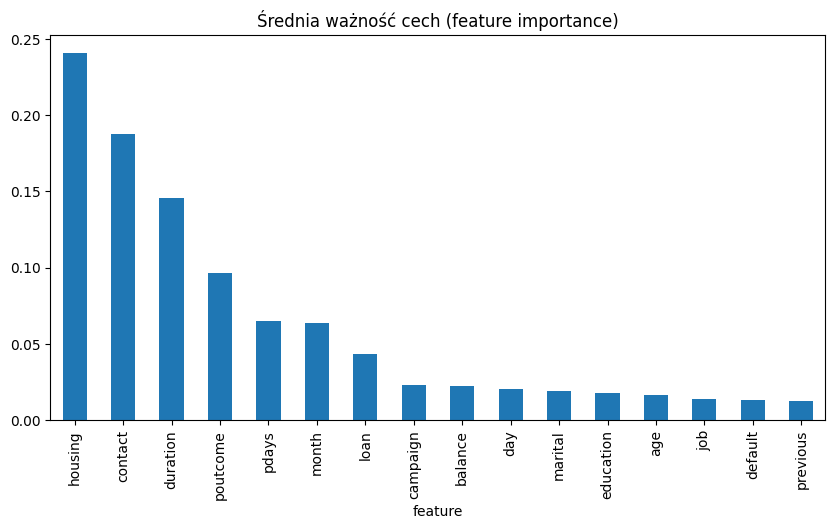

In [29]:
train_model(X, y, beeest_param)

In [ ]:
# V41
## RAW DATA  With optuna XGBoost 5 folds, z previuous, bez scale_pos_weight,
# Public LB Score = -------------- bez z CV w Submission 
# Public LB Score = 0.97248  z CV w Submission 

# Trial 1 finished with value: 0.9715865904724591 and parameters: {'max_depth': 14, 'learning_rate': 0.01624073742578193, 'n_estimators': 1632, 'subsample': 0.899429787551878, 'colsample_bytree': 0.6185268489803915, 'gamma': 0.36362513980290667, 'reg_alpha': 0.744367728380721, 'reg_lambda': 0.4628340619185789, 'min_child_weight': 9, 'max_bin': 1401, 'grow_policy': 'lossguide'}

Fold 1 ROC-AUC: 0.97236
Fold 2 ROC-AUC: 0.97114
Fold 3 ROC-AUC: 0.97101
Fold 4 ROC-AUC: 0.97196
Fold 5 ROC-AUC: 0.97151

Średni ROC-AUC: 0.97160

Feature Importances:
       feature  importance
6     contact    0.198861
12   duration    0.167826
4     housing    0.138277
8    poutcome    0.137458
7       month    0.066364
5        loan    0.066318
14      pdays    0.055454
15   previous    0.023862
10    balance    0.022934
11        day    0.020478
1     marital    0.020246
13   campaign    0.019228
3     default    0.016890
9         age    0.015989
2   education    0.015786
0         job    0.014029

In [ ]:
# V42
## RAW DATA  With optuna XGBoost 5 folds, z previuous, bez scale_pos_weight,
# Public LB Score = -------------- bez z CV w Submission 
# Public LB Score = 0.97316 z CV w Submission 

#Trial 11 finished with value: 0.9718884977490984 and parameters: {'max_depth': 19, 'learning_rate': 0.08091498981682245, 'n_estimators': 300, 'subsample': 0.8533765487098182, 'colsample_bytree': 0.6026759464047292, 'gamma': 0.0043501519621497176, 'reg_alpha': 3.4621137407155906, 'reg_lambda': 0.07698105946770128, 'min_child_weight': 1, 'max_bin': 2019, 'grow_policy': 'lossguide'}

Fold 1 ROC-AUC: 0.97269
Fold 2 ROC-AUC: 0.97152
Fold 3 ROC-AUC: 0.97113
Fold 4 ROC-AUC: 0.97229
Fold 5 ROC-AUC: 0.97184

Średni ROC-AUC: 0.97189

Feature Importances:
       feature  importance
12   duration    0.192274
4     housing    0.163926
6     contact    0.159542
7       month    0.084574
8    poutcome    0.080662
14      pdays    0.078938
5        loan    0.046858
10    balance    0.032551
11        day    0.028901
13   campaign    0.024628
1     marital    0.022266
9         age    0.020955
2   education    0.019305
0         job    0.017373
15   previous    0.016016
3     default    0.011230


In [ ]:
# V43
## RAW DATA  With optuna XGBoost 5 folds, z previuous, bez scale_pos_weight,
# Public LB Score = -------------- bez z CV w Submission 
# Public LB Score = 0,97282 z CV w Submission 

#vTrial 15 finished with value: 0.9717732494056683 and parameters: {'max_depth': 17, 'learning_rate': 0.06519980970054881, 'n_estimators': 680, 'subsample': 0.8736025882716271, 'colsample_bytree': 0.875664321925202, 'gamma': 1.174374070219337, 'reg_alpha': 4.517748889976481, 'reg_lambda': 0.8719349977849177, 'min_child_weight': 5, 'max_bin': 1770, 'grow_policy': 'lossguide'}

Fold 1 ROC-AUC: 0.97257
Fold 2 ROC-AUC: 0.97149
Fold 3 ROC-AUC: 0.97134
Fold 4 ROC-AUC: 0.97222
Fold 5 ROC-AUC: 0.97177

Średni ROC-AUC: 0.97188

Feature Importances:
       feature  importance
4     housing    0.252498
6     contact    0.221672
12   duration    0.145096
8    poutcome    0.092546
14      pdays    0.063781
7       month    0.052611
5        loan    0.043339
13   campaign    0.020093
10    balance    0.018717
11        day    0.016958
1     marital    0.016530
2   education    0.014053
9         age    0.012917
0         job    0.010208
3     default    0.009907
15   previous    0.009073

In [ ]:
# V44
## RAW DATA  With optuna XGBoost 5 folds, z previuous, bez scale_pos_weight,
# Public LB Score = -------------- bez z CV w Submission 
# Public LB Score = 0,97299 z CV w Submission 

#Trial 13 finished with value: 0.972124477830939 and parameters: {'max_depth': 18, 'learning_rate': 0.0708831450623464, 'n_estimators': 553, 'subsample': 0.8546933847917322, 'colsample_bytree': 0.7477903378445798, 'gamma': 1.196030349250854, 'reg_alpha': 3.387163897627949, 'reg_lambda': 0.8826864133067371, 'min_child_weight': 1, 'max_bin': 2022, 'grow_policy': 'lossguide'}
    
Fold 1 ROC-AUC: 0.97273
Fold 2 ROC-AUC: 0.97155
Fold 3 ROC-AUC: 0.97147
Fold 4 ROC-AUC: 0.97244
Fold 5 ROC-AUC: 0.97187

Średni ROC-AUC: 0.97201

Feature Importances:
       feature  importance
4     housing    0.243209
6     contact    0.185113
12   duration    0.142803
8    poutcome    0.099292
14      pdays    0.066120
7       month    0.061654
5        loan    0.051452
10    balance    0.023324
13   campaign    0.020940
11        day    0.020490
1     marital    0.018648
9         age    0.016422
2   education    0.015506
0         job    0.012743
15   previous    0.011924
3     default    0.010359

In [ ]:
# V45
## RAW DATA  With optuna XGBoost 5 folds, z previuous, bez scale_pos_weight,
# Public LB Score = -------------- bez z CV w Submission 
# Public LB Score = 0.97344 z CV w Submission 

Trial 19 finished with value: 0.972428270544175 and parameters: {'max_depth': 16, 'learning_rate': 0.0444106455843034, 'n_estimators': 2746, 'subsample': 0.8385441637974808, 'colsample_bytree': 0.8660799923129452, 'gamma': 0.6988818955694143, 'reg_alpha': 4.026337640164294, 'reg_lambda': 4.0256180856994215, 'min_child_weight': 3, 'max_bin': 1904, 'grow_policy': 'lossguide'}

Fold 1 ROC-AUC: 0.97322
Fold 2 ROC-AUC: 0.97202
Fold 3 ROC-AUC: 0.97177
Fold 4 ROC-AUC: 0.97278
Fold 5 ROC-AUC: 0.97241

Średni ROC-AUC: 0.97244

Feature Importances:
       feature  importance
4     housing    0.240487
6     contact    0.187580
12   duration    0.145691
8    poutcome    0.096370
14      pdays    0.064628
7       month    0.063831
5        loan    0.043229
13   campaign    0.022724
10    balance    0.022455
11        day    0.020449
1     marital    0.019210
2   education    0.017432
9         age    0.016351
0         job    0.013964
3     default    0.013399
15   previous    0.012203


In [ ]:
## CV 10 folds no previuous i z previous // n_trials = 100 /150 

In [ ]:
# n estimators 20000 i erly stopping

In [ ]:
# CATBOOST LIGHTXGBoost

In [ ]:

a=[
{'Model': 'XGBClassifier', 'ver':19, 'avg ROC-AUC':0.96788 , 'Public LB CV': 0.96924, 'Public LB no CV': 0.96878, 'Optuna n-trial': 30,  'CV folds-train': 5, 'Raw_data':'Yes','scale_pos_weight':'Yes','del_columns':''               ,'opt_hyp_param':8 ,'New_columns':'' ,'Add_conditions': '', 'Best params': {'max_depth': 10, 'learning_rate': 0.088542375425159, 'n_estimators': 353, 'subsample': 0.7933680125492807, 'colsample_bytree': 0.665859932215261, 'gamma': 1.9591038948726576, 'reg_alpha': 4.135658777432998, 'reg_lambda': 3.0378978111339086}}, 
{'Model': 'XGBClassifier', 'ver':20, 'avg ROC-AUC':0.96787 , 'Public LB CV': 0.96942, 'Public LB no CV': 0.96914, 'Optuna n-trial': 30,  'CV folds-train': 5, 'Raw_data':'No', 'scale_pos_weight':'Yes','del_columns':'previous'       ,'opt_hyp_param':8 ,'New_columns':'' ,'Add_conditions': '', 'Best params':  {'max_depth': 9, 'learning_rate': 0.11410300715659989, 'n_estimators': 368, 'subsample': 0.907977121199552, 'colsample_bytree': 0.6014268962223818, 'gamma': 0.7012459904827175, 'reg_alpha': 4.361523501536162, 'reg_lambda': 4.294305690785547}},
{'Model': 'XGBClassifier', 'ver':21, 'avg ROC-AUC':0.96775 , 'Public LB CV': 0.96891, 'Public LB no CV': 0.96844, 'Optuna n-trial': 30,  'CV folds-train': 5, 'Raw_data':'No', 'scale_pos_weight':'Yes','del_columns':'previous'       ,'opt_hyp_param':8 ,'New_columns':'' ,'Add_conditions': 'enable_categorical=True', 'Best params':  {'max_depth': 8, 'learning_rate': 0.07733762308533498, 'n_estimators': 469, 'subsample': 0.9190881144681935, 'colsample_bytree': 0.7461531023839627, 'gamma': 2.06998675412871, 'reg_alpha': 1.3641260353935682, 'reg_lambda': 4.343504135311625}},
{'Model': 'XGBClassifier', 'ver':22, 'avg ROC-AUC':0.96765 , 'Public LB CV': 0.96886, 'Public LB no CV': 0.96848, 'Optuna n-trial': 30,  'CV folds-train': 5, 'Raw_data':'No', 'scale_pos_weight':'Yes','del_columns':'previous,pdays','opt_hyp_param':8 ,'New_columns':'no_previous_contact,pdays_cleaned,loan_plus_housing,deep_debt' ,'Add_conditions': 'days as category,', 'Best params':  {'max_depth': 9, 'learning_rate': 0.07135259874564061, 'n_estimators': 530, 'subsample': 0.8521429564138164, 'colsample_bytree': 0.7823863939520701, 'gamma': 2.9329829182260148, 'reg_alpha': 3.2901322430190185, 'reg_lambda': 1.268405294791835}},
{'Model': 'XGBClassifier', 'ver':23, 'avg ROC-AUC':0.96782 , 'Public LB CV': 0.96895, 'Public LB no CV': 0.96870, 'Optuna n-trial': 30,  'CV folds-train': 5, 'Raw_data':'No', 'scale_pos_weight':'Yes','del_columns':'previous,pdays','opt_hyp_param':8 ,'New_columns':'no_previous_contact,pdays_cleaned,loan_plus_housing' ,'Add_conditions': 'days as category', 'Best params': {'max_depth': 8, 'learning_rate': 0.12763052427108496, 'n_estimators': 411, 'subsample': 0.953989568332575, 'colsample_bytree': 0.6023438935073028, 'gamma': 0.019491768244553676, 'reg_alpha': 3.961328967768697, 'reg_lambda': 1.131707666650681} },
{'Model': 'XGBClassifier', 'ver':24, 'avg ROC-AUC':0.96756 , 'Public LB CV': 0.96867, 'Public LB no CV': 0.96831, 'Optuna n-trial': 30,  'CV folds-train': 5, 'Raw_data':'No', 'scale_pos_weight':'Yes','del_columns':'previous,pdays','opt_hyp_param':8 ,'New_columns':'no_previous_contact,pdays_cleaned,loan_plus_housing,no_count,unknown_count' ,'Add_conditions': 'days as category', 'Best params': {'max_depth': 7, 'learning_rate': 0.16686222138398568, 'n_estimators': 359, 'subsample': 0.9687425335082887, 'colsample_bytree': 0.8948829860260885, 'gamma': 0.3972938375538543, 'reg_alpha': 4.575416910972401, 'reg_lambda': 2.201098085025244} },
{'Model': 'XGBClassifier', 'ver':25, 'avg ROC-AUC':0.96792 , 'Public LB CV': 0.96900, 'Public LB no CV': 0.96883, 'Optuna n-trial': 30,  'CV folds-train': 5, 'Raw_data':'No' ,'scale_pos_weight':'Yes','del_columns':'previous,pdays','opt_hyp_param':8 ,'New_columns':'no_previous_contact,pdays_cleaned,no_count,unknown_count' ,'Add_conditions': 'days as category', 'Best params': {'max_depth': 10, 'learning_rate': 0.05576641173716932, 'n_estimators': 492, 'subsample': 0.7568779660915822, 'colsample_bytree': 0.6384212073745787, 'gamma': 2.0698430928317997, 'reg_alpha': 2.9165075287479447, 'reg_lambda': 2.040935203862332} },
{'Model': 'XGBClassifier', 'ver':26, 'avg ROC-AUC':0.96779 , 'Public LB CV': 0.96911, 'Public LB no CV':''     ,  'Optuna n-trial': 30,  'CV folds-train': 5, 'Raw_data':'No' ,'scale_pos_weight':'Yes','del_columns':'previous,pdays','opt_hyp_param':8 ,'New_columns':'no_previous_contact,pdays_cleaned','Add_conditions': '', 'Best params': {'max_depth': 10, 'learning_rate': 0.0832583908499121, 'n_estimators': 551, 'subsample': 0.8758220883852462, 'colsample_bytree': 0.6810585417529508, 'gamma': 2.389202320659961, 'reg_alpha': 0.9587487104983587, 'reg_lambda': 4.103575772005836} },
{'Model': 'XGBClassifier', 'ver':27, 'avg ROC-AUC':0.96786 , 'Public LB CV': 0.96901, 'Public LB no CV':''     ,  'Optuna n-trial': 30,  'CV folds-train': 5, 'Raw_data':'No' ,'scale_pos_weight':'Yes','del_columns':'previous'       ,'opt_hyp_param':8 ,'New_columns':'no_count' ,'Add_conditions':'', 'Best params': {'max_depth': 11, 'learning_rate': 0.07256654502258869, 'n_estimators': 264, 'subsample': 0.7252245807583018, 'colsample_bytree': 0.7225278113013671, 'gamma': 3.044364512727718, 'reg_alpha': 4.9552240198208874, 'reg_lambda': 3.7933495200093277} },
{'Model': 'XGBClassifier', 'ver':28, 'avg ROC-AUC':0.96787 , 'Public LB CV': 0.96913, 'Public LB no CV':''     ,  'Optuna n-trial': 30,  'CV folds-train': 5, 'Raw_data':'No' ,'scale_pos_weight':'Yes','del_columns':'previous'       ,'opt_hyp_param':8 ,'New_columns':'unknown_count' ,'Add_conditions':'', 'Best params': {'max_depth': 11, 'learning_rate': 0.05314481725365295, 'n_estimators': 485, 'subsample': 0.6616608475014232, 'colsample_bytree': 0.6827154636682595, 'gamma': 1.99699754127895, 'reg_alpha': 3.8063665621075478, 'reg_lambda': 1.325699284371194} },
{'Model': 'XGBClassifier', 'ver':30, 'avg ROC-AUC':0.96812 , 'Public LB CV': 0.96933, 'Public LB no CV':''     ,  'Optuna n-trial': 30,  'CV folds-train': 5, 'Raw_data':'No' ,'scale_pos_weight':'No' ,'del_columns':'previous'       ,'opt_hyp_param':8 ,'New_columns':'' ,'Add_conditions': '', 'Best params': {'max_depth': 11, 'learning_rate': 0.11206031547278855, 'n_estimators': 501, 'subsample': 0.6131323770348673, 'colsample_bytree': 0.6094568889243491, 'gamma': 2.043078715855179, 'reg_alpha': 2.0852138450654643, 'reg_lambda': 4.796903414902333} },
{'Model': 'XGBClassifier', 'ver':31, 'avg ROC-AUC':0.96819 , 'Public LB CV': 0.96955, 'Public LB no CV':''     ,  'Optuna n-trial': 30,  'CV folds-train': 5, 'Raw_data':'Yes','scale_pos_weight':'No' ,'del_columns':''               ,'opt_hyp_param':8 ,'New_columns':'' ,'Add_conditions': '', 'Best params': {'max_depth': 9, 'learning_rate': 0.12075088743052882, 'n_estimators': 492, 'subsample': 0.8707220500188539, 'colsample_bytree': 0.6688353258198634, 'gamma': 0.7893885646435537, 'reg_alpha': 0.7438751764100405, 'reg_lambda': 3.4902318090320925} },
{'Model': 'XGBClassifier', 'ver':32, 'avg ROC-AUC':0.96849 , 'Public LB CV': 0.96944, 'Public LB no CV':''     ,  'Optuna n-trial': 30,  'CV folds-train': 10,'Raw_data':'Yes','scale_pos_weight':'No' ,'del_columns':''               ,'opt_hyp_param':8 ,'New_columns':'' ,'Add_conditions': '', 'Best params': {'max_depth': 9, 'learning_rate': 0.06227423103688831, 'n_estimators': 556, 'subsample': 0.9298469326500857, 'colsample_bytree': 0.8895510541144902, 'gamma': 0.48209725496163736, 'reg_alpha': 3.796950975692023, 'reg_lambda': 1.6612550809713749} },
{'Model': 'XGBClassifier', 'ver':33, 'avg ROC-AUC':0.96801 , 'Public LB CV': 0.96903, 'Public LB no CV':''     ,  'Optuna n-trial': 30,  'CV folds-train': 10,'Raw_data':'No' ,'scale_pos_weight':'Yes','del_columns':'previous'       ,'opt_hyp_param':8 ,'New_columns':'' ,'Add_conditions': '', 'Best params': {'max_depth': 11, 'learning_rate': 0.04545133522176488, 'n_estimators': 481, 'subsample': 0.7684178974094136, 'colsample_bytree': 0.7986253830153623, 'gamma': 4.481651671654932, 'reg_alpha': 3.3989357087069094, 'reg_lambda': 0.557383341841934} },
{'Model': 'XGBClassifier', 'ver':34, 'avg ROC-AUC':0.97010 , 'Public LB CV': 0.97147, 'Public LB no CV':''     ,  'Optuna n-trial': 40,  'CV folds-train': 5, 'Raw_data':'No' ,'scale_pos_weight':'Yes','del_columns':'previous'       ,'opt_hyp_param':11,'New_columns':'' ,'Add_conditions': '', 'Best params': {'max_depth': 11, 'learning_rate': 0.11017938521753814, 'n_estimators': 447, 'subsample': 0.7200594556282529, 'colsample_bytree': 0.7298687513204829, 'gamma': 3.7349463296256253, 'reg_alpha': 2.2870628091572853, 'reg_lambda': 0.3821213759830635, 'min_child_weight': 22, 'max_bin': 965, 'grow_policy': 'lossguide'} },
{'Model': 'XGBClassifier', 'ver':35, 'avg ROC-AUC':0.97018 , 'Public LB CV': 0.97150, 'Public LB no CV':''     ,  'Optuna n-trial': 40,  'CV folds-train': 5, 'Raw_data':'Yes','scale_pos_weight':'No' ,'del_columns':''               ,'opt_hyp_param':11,'New_columns':'' ,'Add_conditions': '', 'Best params': {'max_depth': 10, 'learning_rate': 0.11419656400547268, 'n_estimators': 382, 'subsample': 0.8761249869278733, 'colsample_bytree': 0.9302155455418724, 'gamma': 0.922723932134517, 'reg_alpha': 1.0912230662828875, 'reg_lambda': 2.6136637861620295, 'min_child_weight': 23, 'max_bin': 923, 'grow_policy': 'lossguide'} },
{'Model': 'XGBClassifier', 'ver':36, 'avg ROC-AUC':0.97005 , 'Public LB CV': 0.97142, 'Public LB no CV':''     ,  'Optuna n-trial': 40,  'CV folds-train': 5, 'Raw_data':'Yes','scale_pos_weight':'Yes','del_columns':''               ,'opt_hyp_param':11,'New_columns':'' ,'Add_conditions': '', 'Best params': {'max_depth': 10, 'learning_rate': 0.08502933965618005, 'n_estimators': 492, 'subsample': 0.8475568692723069, 'colsample_bytree': 0.7937125702771929, 'gamma': 2.090595137285895, 'reg_alpha': 2.2649299117163197, 'reg_lambda': 4.582521266327681, 'min_child_weight': 18, 'max_bin': 850, 'grow_policy': 'lossguide'} },
{'Model': 'XGBClassifier', 'ver':37, 'avg ROC-AUC':0.97068 , 'Public LB CV': 0.97179, 'Public LB no CV':''     ,  'Optuna n-trial': 150, 'CV folds-train': 5, 'Raw_data':'No' ,'scale_pos_weight':'Yes','del_columns':'previous'       ,'opt_hyp_param':11,'New_columns':'' ,'Add_conditions': 'n_estim, max_dep increased', 'Best params': {'max_depth': 13, 'learning_rate': 0.051597964533266545, 'n_estimators': 1199, 'subsample': 0.9486843342638015, 'colsample_bytree': 0.7012804860738411, 'gamma': 1.4669905642678631, 'reg_alpha': 3.8750691242340927, 'reg_lambda': 3.5772297879036534, 'min_child_weight': 17, 'max_bin': 1024, 'grow_policy': 'depthwise'} },
{'Model': 'XGBClassifier', 'ver':38, 'avg ROC-AUC':0.96976 , 'Public LB CV': 0.97147, 'Public LB no CV':''     ,  'Optuna n-trial': 40,  'CV folds-train': 5, 'Raw_data':'No' ,'scale_pos_weight':'Yes','del_columns':'previous'       ,'opt_hyp_param':11,'New_columns':'day_of_year_sin,day_of_year_cos' ,'Add_conditions': '', 'Best params': {'max_depth': 10, 'learning_rate': 0.12547508160977527, 'n_estimators': 558, 'subsample': 0.9603467732508381, 'colsample_bytree': 0.6775794698624192, 'gamma': 1.0653180442504713, 'reg_alpha': 3.49579539155107, 'reg_lambda': 3.985155368089634, 'min_child_weight': 12, 'max_bin': 787, 'grow_policy': 'lossguide'} },
##{'Model': 'XGBClassifier', 'ver':36, 'avg ROC-AUC':0.97005 , 'Public LB CV': 0.97142, 'Public LB no CV': np.nan,  'Optuna n-trial': 40,  'CV folds-train': 5, 'Raw_data':'Yes','scale_pos_weight':'Yes','del_columns':''               ,'opt_hyp_param':11,'New_columns':'' ,'Add_conditions': '', 'Best params':  },
##{'Model': 'XGBClassifier', 'ver':36, 'avg ROC-AUC':0.97005 , 'Public LB CV': 0.97142, 'Public LB no CV': np.nan,  'Optuna n-trial': 40,  'CV folds-train': 5, 'Raw_data':'Yes','scale_pos_weight':'Yes','del_columns':''               ,'opt_hyp_param':11,'New_columns':'' ,'Add_conditions': '', 'Best params':  },    
]


In [ ]:
df_a = pd.DataFrame(a)
df_a.iloc[:, :-1]

In [ ]:
import optuna
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

def optuna_search(n_trials=30, early_stopping_rounds=300):
    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 3, 11),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
            'n_estimators': 10000,  # stała wartość, early stopping to ograniczy
            'eval_metric': 'auc',
            'use_label_encoder': False,
            'n_jobs': -1
        }

        scores = []
        for train_idx, val_idx in kf.split(X, y):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

            model = XGBClassifier(**params,
                                  scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())

            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                early_stopping_rounds=early_stopping_rounds,
                verbose=False
            )

            y_pred = model.predict_proba(X_val)[:, 1]
            auc = roc_auc_score(y_val, y_pred)
            scores.append(auc)

        return np.mean(scores)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    print("\n🎯 Najlepsze parametry Optuna:\n", study.best_params)
    print(f"🏆 Najlepszy ROC-AUC: {study.best_value:.5f}")

    # Trenowanie najlepszego modelu na całych danych
    best_params = study.best_params
    best_params['n_estimators'] = 10000
    best_params['eval_metric'] = 'auc'
    best_params['use_label_encoder'] = False
    best_params['n_jobs'] = -1

    final_model = XGBClassifier(**best_params,
                                scale_pos_weight=(y == 0).sum() / (y == 1).sum())

    final_model.fit(X, y, early_stopping_rounds=early_stopping_rounds, eval_set=[(X, y)], verbose=False)

    return final_model

In [ ]:
# Po zakończeniu fitowania z eval_set i early_stopping
best_n_estimators = model.best_iteration

# Trenujesz finalny model na całym zbiorze danych:
final_model = XGBClassifier(
    **study.best_params,
    n_estimators=best_n_estimators,
    use_label_encoder=False,
    eval_metric='auc',
    n_jobs=-1
)

final_model.fit(X, y)

 Uwagi:
To podejście łączy maksymalne wykorzystanie danych z optymalną liczbą iteracji.

Jest to powszechnie używana technika w realnych projektach.

Warto zapisać best_iteration po każdej foldzie podczas cross-validacji i np. uśrednić, jeśli chcesz mieć bardziej ogólny n_estimators.

# -----------------------------------------------------
# Optuna z early stopping i n_estimators = 20000
# -----------------------------------------------------

In [7]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e8/train.csv')

In [8]:
# ==== WPROWADŹ SWOJE KOLUMNY ====
categorical_cols = [ 'job', 'marital','education','default','housing','loan','contact','month','poutcome']#,  'no_count', 'unknown_count' ]  # 'loan_plus_housing', <- wpisz swoje kolumny kategoryczne
numerical_cols = ['age','balance', 'day', 'duration', 'campaign', 'pdays', 'previous']#'day_of_year_sin', 'day_of_year_cos' ]#, 'previous' ]#'pdays']#, 'previous']    # <- wpisz swoje kolumny numeryczne
target_col = 'y'


In [9]:
# Przygotowanie danych
df = train_df.copy()
X = df[categorical_cols + numerical_cols].copy()
y = df[target_col].copy()

# Label encoding dla kolumn kategorycznych
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# -----------------------------------------------------
# Funkcja trenowania z dużym n_estimators + early stopping
# -----------------------------------------------------
def train_model(X, y, params):
    scores = []
    importances = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        model = XGBClassifier(
            **params,
            eval_metric='auc',
            use_label_encoder=False,
            early_stopping_rounds=300,
            n_jobs=-1
        )

        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            #early_stopping_rounds=300,
            verbose=False
        )

        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        importances.append(model.feature_importances_)

        print(f"Fold {fold+1} ROC-AUC: {auc:.5f} | Trees used: {model.best_iteration}")
        print(f"[Train model] Fold {fold+1} - Best iteration: {model.best_iteration+1}")

    print(f"\nŚredni ROC-AUC: {np.mean(scores):.5f}")
    avg_importances = np.mean(importances, axis=0)

    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': avg_importances
    }).sort_values(by='importance', ascending=False)

    print("\nFeature Importances:\n", importance_df)

    importance_df.plot.bar(x='feature', y='importance', legend=False, figsize=(10,5))
    plt.title("Średnia ważność cech (feature importance)")
    plt.show()



# -----------------------------------------------------
# Optuna z early stopping (n_estimators na stałe)
# -----------------------------------------------------

In [11]:
def optuna_search(n_trials=30):
    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 7, 15),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 28),
            'max_bin': trial.suggest_int('max_bin', 256, 1024),
            'grow_policy': 'lossguide',
            'n_estimators': 20000
            #
            # 'max_depth': trial.suggest_int('max_depth', 2, 8),  # mniejsze, bo loss guide i max_leaves kontroluje złożoność
            # 'max_leaves': trial.suggest_int('max_leaves', 256, 2048),  # nowy parametr
            # 'learning_rate': trial.suggest_float('learning_rate', 0.015, 0.05),  # zawężone wokół 0.027
            # 'n_estimators': 20000,  # stałe w paramach
            # 'subsample': trial.suggest_float('subsample', 0.75, 0.9),  # wąsko wokół 0.80
            # 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.75),  # wokół 0.61
            # 'gamma': trial.suggest_float('gamma', 0.3, 1.0),  # wokół 0.45
            # 'reg_alpha': trial.suggest_float('reg_alpha', 0.8, 1.5),  # wokół 1.13
            # 'reg_lambda': trial.suggest_float('reg_lambda', 1.2, 2.0),  # wokół 1.60
            # 'min_child_weight': trial.suggest_int('min_child_weight', 15, 25),  # wokół 18
            # 'max_bin': trial.suggest_int('max_bin', 900, 1024),  # wokół 989
            # 'grow_policy': 'lossguide'
        }

        scores = []
        fold_num = 1
        for train_idx, val_idx in kf.split(X, y):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

            model = XGBClassifier(
                **params,
                eval_metric='auc',
                use_label_encoder=False,
                n_jobs=-1,
                early_stopping_rounds=300, #wstAW TUTAJ BY NIE bylo warningow
            )

            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                #early_stopping_rounds=300,
                verbose=False
            )
            
            print(f"[Optuna] Fold {fold_num} - Best iteration: {model.best_iteration+1}")
            fold_num += 1

            y_pred = model.predict_proba(X_val)[:, 1]
            auc = roc_auc_score(y_val, y_pred)
            scores.append(auc)

        return np.mean(scores)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    # Przekazanie stałych parametró (nie są zapisywane przez optunę do best_params)
    best_params = study.best_params.copy()
    best_params.update({'grow_policy': 'lossguide','n_estimators': 20000})
    
    print("\nNajlepsze parametry Optuna:\n", best_params)
    print(f"Najlepszy ROC-AUC: {study.best_value:.5f}")

    # Trening finalny z najlepszymi parametrami
    train_model(X, y, best_params)

[I 2025-08-15 12:52:31,000] A new study created in memory with name: no-name-ee72bfb4-e84f-45ff-aca9-3a9540a573a0


[Optuna] Fold 1 - Best iteration: 666
[Optuna] Fold 2 - Best iteration: 783
[Optuna] Fold 3 - Best iteration: 1089
[Optuna] Fold 4 - Best iteration: 1253
[Optuna] Fold 5 - Best iteration: 2309


[I 2025-08-15 12:59:26,937] Trial 0 finished with value: 0.9689414369804863 and parameters: {'max_depth': 9, 'learning_rate': 0.08841770198370769, 'subsample': 0.9967677620494778, 'colsample_bytree': 0.7720512336812402, 'gamma': 0.19712696220351988, 'reg_alpha': 0.3575734349734866, 'reg_lambda': 0.11552296031121956, 'min_child_weight': 25, 'max_bin': 332}. Best is trial 0 with value: 0.9689414369804863.


[Optuna] Fold 1 - Best iteration: 2681
[Optuna] Fold 2 - Best iteration: 2937
[Optuna] Fold 3 - Best iteration: 2123
[Optuna] Fold 4 - Best iteration: 2203
[Optuna] Fold 5 - Best iteration: 2361


[I 2025-08-15 13:12:34,446] Trial 1 finished with value: 0.9694584265064592 and parameters: {'max_depth': 13, 'learning_rate': 0.07339543827561079, 'subsample': 0.6366734721874053, 'colsample_bytree': 0.6801872526802053, 'gamma': 1.69281279256495, 'reg_alpha': 3.765615531823302, 'reg_lambda': 3.867561411004231, 'min_child_weight': 23, 'max_bin': 447}. Best is trial 1 with value: 0.9694584265064592.


[Optuna] Fold 1 - Best iteration: 1220
[Optuna] Fold 2 - Best iteration: 382
[Optuna] Fold 3 - Best iteration: 753
[Optuna] Fold 4 - Best iteration: 1898
[Optuna] Fold 5 - Best iteration: 497


[I 2025-08-15 13:17:28,391] Trial 2 finished with value: 0.9680524285610973 and parameters: {'max_depth': 11, 'learning_rate': 0.08311664889571836, 'subsample': 0.972511459413268, 'colsample_bytree': 0.8366818157797714, 'gamma': 2.857350200346068, 'reg_alpha': 4.49037356863569, 'reg_lambda': 0.7612796368942903, 'min_child_weight': 19, 'max_bin': 661}. Best is trial 1 with value: 0.9694584265064592.


[Optuna] Fold 1 - Best iteration: 875
[Optuna] Fold 2 - Best iteration: 859
[Optuna] Fold 3 - Best iteration: 1174
[Optuna] Fold 4 - Best iteration: 2805
[Optuna] Fold 5 - Best iteration: 1371


[I 2025-08-15 13:23:31,398] Trial 3 finished with value: 0.9668199314852484 and parameters: {'max_depth': 9, 'learning_rate': 0.15964898215431053, 'subsample': 0.9403752755792234, 'colsample_bytree': 0.9382054098433721, 'gamma': 4.583533434145313, 'reg_alpha': 3.411824469833466, 'reg_lambda': 3.233937281545021, 'min_child_weight': 24, 'max_bin': 442}. Best is trial 1 with value: 0.9694584265064592.


[Optuna] Fold 1 - Best iteration: 377
[Optuna] Fold 2 - Best iteration: 394
[Optuna] Fold 3 - Best iteration: 416
[Optuna] Fold 4 - Best iteration: 331
[Optuna] Fold 5 - Best iteration: 380


[I 2025-08-15 13:29:42,884] Trial 4 finished with value: 0.9695249984591154 and parameters: {'max_depth': 14, 'learning_rate': 0.0794092297508279, 'subsample': 0.7396498673680281, 'colsample_bytree': 0.9898654084134362, 'gamma': 0.5001181239388003, 'reg_alpha': 0.3834301716381272, 'reg_lambda': 1.3063601489798804, 'min_child_weight': 16, 'max_bin': 631}. Best is trial 4 with value: 0.9695249984591154.


[Optuna] Fold 1 - Best iteration: 2449
[Optuna] Fold 2 - Best iteration: 4419
[Optuna] Fold 3 - Best iteration: 4547
[Optuna] Fold 4 - Best iteration: 4345
[Optuna] Fold 5 - Best iteration: 3866


[I 2025-08-15 13:45:44,915] Trial 5 finished with value: 0.9703155265679175 and parameters: {'max_depth': 8, 'learning_rate': 0.15662105526780598, 'subsample': 0.7232171262618272, 'colsample_bytree': 0.6366668920915555, 'gamma': 2.247145559992434, 'reg_alpha': 1.31584775922535, 'reg_lambda': 3.945060378094036, 'min_child_weight': 23, 'max_bin': 912}. Best is trial 5 with value: 0.9703155265679175.


[Optuna] Fold 1 - Best iteration: 7288
[Optuna] Fold 2 - Best iteration: 6382
[Optuna] Fold 3 - Best iteration: 6849
[Optuna] Fold 4 - Best iteration: 9419
[Optuna] Fold 5 - Best iteration: 3690


[I 2025-08-15 14:10:40,026] Trial 6 finished with value: 0.9699521450229776 and parameters: {'max_depth': 15, 'learning_rate': 0.16524796592466132, 'subsample': 0.7183467571540946, 'colsample_bytree': 0.9609379754479955, 'gamma': 3.4689440439213817, 'reg_alpha': 2.242928674016076, 'reg_lambda': 1.8765537266700483, 'min_child_weight': 9, 'max_bin': 777}. Best is trial 5 with value: 0.9703155265679175.


[Optuna] Fold 1 - Best iteration: 16005
[Optuna] Fold 2 - Best iteration: 16356
[Optuna] Fold 3 - Best iteration: 14037
[Optuna] Fold 4 - Best iteration: 16537
[Optuna] Fold 5 - Best iteration: 16741


[I 2025-08-15 15:22:42,088] Trial 7 finished with value: 0.9706474766357169 and parameters: {'max_depth': 7, 'learning_rate': 0.016481328062564214, 'subsample': 0.78538575960754, 'colsample_bytree': 0.8398589493683006, 'gamma': 1.1562617855827413, 'reg_alpha': 4.362527205707105, 'reg_lambda': 2.251389765899588, 'min_child_weight': 25, 'max_bin': 880}. Best is trial 7 with value: 0.9706474766357169.


[Optuna] Fold 1 - Best iteration: 4169
[Optuna] Fold 2 - Best iteration: 5347
[Optuna] Fold 3 - Best iteration: 4034
[Optuna] Fold 4 - Best iteration: 5713
[Optuna] Fold 5 - Best iteration: 2468


[I 2025-08-15 15:43:48,687] Trial 8 finished with value: 0.9699305594072808 and parameters: {'max_depth': 13, 'learning_rate': 0.03891459897544601, 'subsample': 0.6147171009859792, 'colsample_bytree': 0.9019418949258028, 'gamma': 2.2621758818136395, 'reg_alpha': 1.381641129729791, 'reg_lambda': 2.8425350137135474, 'min_child_weight': 13, 'max_bin': 578}. Best is trial 7 with value: 0.9706474766357169.


[Optuna] Fold 1 - Best iteration: 460
[Optuna] Fold 2 - Best iteration: 855
[Optuna] Fold 3 - Best iteration: 2127
[Optuna] Fold 4 - Best iteration: 2248
[Optuna] Fold 5 - Best iteration: 3363


[I 2025-08-15 15:51:07,692] Trial 9 finished with value: 0.9660727167250783 and parameters: {'max_depth': 7, 'learning_rate': 0.1288343668341127, 'subsample': 0.9422688550231766, 'colsample_bytree': 0.666114250696812, 'gamma': 4.1353553212154655, 'reg_alpha': 3.8892792082993433, 'reg_lambda': 3.1244065871748745, 'min_child_weight': 23, 'max_bin': 259}. Best is trial 7 with value: 0.9706474766357169.



Najlepsze parametry Optuna:
 {'max_depth': 7, 'learning_rate': 0.016481328062564214, 'subsample': 0.78538575960754, 'colsample_bytree': 0.8398589493683006, 'gamma': 1.1562617855827413, 'reg_alpha': 4.362527205707105, 'reg_lambda': 2.251389765899588, 'min_child_weight': 25, 'max_bin': 880}
Najlepszy ROC-AUC: 0.97065
Fold 1 ROC-AUC: 0.95532 | Trees used: 99
[Train model] Fold 1 - Best iteration: 100
Fold 2 ROC-AUC: 0.95518 | Trees used: 99
[Train model] Fold 2 - Best iteration: 100
Fold 3 ROC-AUC: 0.95454 | Trees used: 99
[Train model] Fold 3 - Best iteration: 100
Fold 4 ROC-AUC: 0.95596 | Trees used: 99
[Train model] Fold 4 - Best iteration: 100
Fold 5 ROC-AUC: 0.95541 | Trees used: 99
[Train model] Fold 5 - Best iteration: 100

Średni ROC-AUC: 0.95528

Feature Importances:
       feature  importance
12   duration    0.319905
6     contact    0.168529
4     housing    0.153896
8    poutcome    0.063694
14      pdays    0.059313
7       month    0.038114
5        loan    0.037439
10    

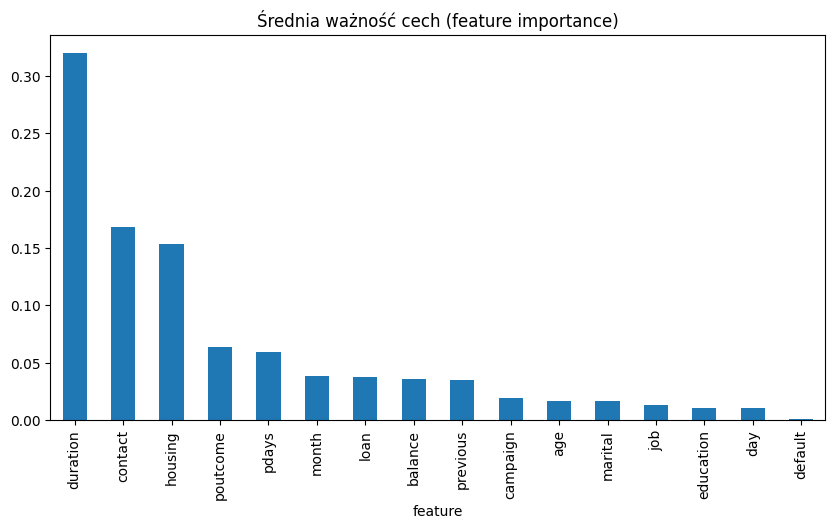

In [12]:
optuna_search(n_trials=10)

In [ ]:
Trial 1 finished with value: 0.970842402423133 and parameters: {'max_depth': 7, 'max_leaves': 1580, 'learning_rate': 0.0231469476935556, 'subsample': 0.8959315213545782, 'colsample_bytree': 0.7226883022153655, 'gamma': 0.5313913167805646, 'reg_alpha': 0.8914512027335614, 'reg_lambda': 1.2570717441067634, 'min_child_weight': 21, 'max_bin': 924, 'grow_policy': 'lossguide','n_estimators': 20000}


In [ ]:
Trial 7 finished with value: 0.9706474766357169 and parameters: {'max_depth': 7, 'learning_rate': 0.016481328062564214, 'subsample': 0.78538575960754, 'colsample_bytree': 0.8398589493683006, 'gamma': 1.1562617855827413, 'reg_alpha': 4.362527205707105, 'reg_lambda': 2.251389765899588, 'min_child_weight': 25, 'max_bin': 880, 'grow_policy': 'lossguide','n_estimators': 20000}
Fold 1 ROC-AUC: 0.97135 | Trees used: 16004
[Train model] Fold 1 - Best iteration: 16005
Fold 2 ROC-AUC: 0.97011 | Trees used: 16355
[Train model] Fold 2 - Best iteration: 16356
Fold 3 ROC-AUC: 0.97004 | Trees used: 14036
[Train model] Fold 3 - Best iteration: 14037
Fold 4 ROC-AUC: 0.97119 | Trees used: 16536
[Train model] Fold 4 - Best iteration: 16537
Fold 5 ROC-AUC: 0.97055 | Trees used: 16740
[Train model] Fold 5 - Best iteration: 16741

Średni ROC-AUC: 0.97065

Feature Importances:
       feature  importance
6     contact    0.201322
4     housing    0.182304
12   duration    0.148678
8    poutcome    0.133213
5        loan    0.068643
7       month    0.059143
14      pdays    0.056424
13   campaign    0.022101
1     marital    0.019592
2   education    0.019174
10    balance    0.018415
11        day    0.018264
15   previous    0.016265
9         age    0.015272
0         job    0.012285
3     default    0.008905

In [13]:
best_params = {'max_depth': 7, 'learning_rate': 0.016481328062564214, 'subsample': 0.78538575960754, 'colsample_bytree': 0.8398589493683006, 'gamma': 1.1562617855827413, 'reg_alpha': 4.362527205707105, 'reg_lambda': 2.251389765899588, 'min_child_weight': 25, 'max_bin': 880}
best_params.update({'grow_policy': 'lossguide','n_estimators': 20000 })

best_params

{'max_depth': 7,
 'learning_rate': 0.016481328062564214,
 'subsample': 0.78538575960754,
 'colsample_bytree': 0.8398589493683006,
 'gamma': 1.1562617855827413,
 'reg_alpha': 4.362527205707105,
 'reg_lambda': 2.251389765899588,
 'min_child_weight': 25,
 'max_bin': 880,
 'grow_policy': 'lossguide',
 'n_estimators': 20000}

Fold 1 ROC-AUC: 0.97135 | Trees used: 16004
[Train model] Fold 1 - Best iteration: 16005
Fold 2 ROC-AUC: 0.97011 | Trees used: 16355
[Train model] Fold 2 - Best iteration: 16356
Fold 3 ROC-AUC: 0.97004 | Trees used: 14036
[Train model] Fold 3 - Best iteration: 14037
Fold 4 ROC-AUC: 0.97119 | Trees used: 16536
[Train model] Fold 4 - Best iteration: 16537
Fold 5 ROC-AUC: 0.97055 | Trees used: 16740
[Train model] Fold 5 - Best iteration: 16741

Średni ROC-AUC: 0.97065

Feature Importances:
       feature  importance
6     contact    0.201322
4     housing    0.182304
12   duration    0.148678
8    poutcome    0.133213
5        loan    0.068643
7       month    0.059143
14      pdays    0.056424
13   campaign    0.022101
1     marital    0.019592
2   education    0.019174
10    balance    0.018415
11        day    0.018264
15   previous    0.016265
9         age    0.015272
0         job    0.012285
3     default    0.008905


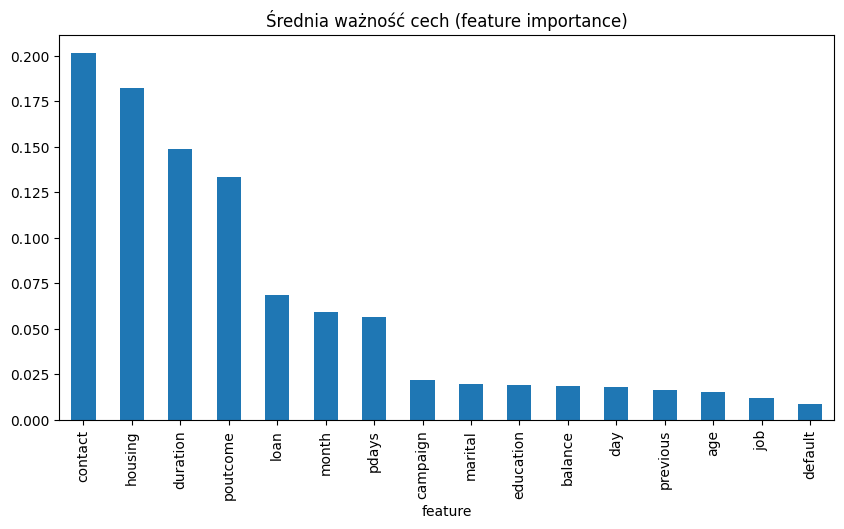

In [14]:
train_model(X, y, best_params)